<a href="https://colab.research.google.com/github/Ravitha/LabelRadiology/blob/master/MIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Imports

In [0]:
#import dicom # some machines not install pydicom
import scipy.misc
import numpy as np 
from sklearn.model_selection import StratifiedKFold
import pickle as cPickle
#import matplotlib
#import matplotlib.pyplot as plt 
from skimage.filters import threshold_otsu
import os
from os.path import join as join
import csv
import scipy.ndimage
#import pydicom as dicom

# Mount Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Compose Dataset

In [0]:
path='/content/drive/My Drive/CO-PO/INBreast'
TrDataset = np.load(join(path,'Train.npy'))
TrLabel = np.load(join(path,'TrainL.npy'))
ValDataset= np.load(join(path,'valid.npy'))
ValLabel = np.load(join(path,'validL.npy'))
TDataset = np.load(join(path,'Test.npy'))
TLabel = np.load(join(path,'TestL.npy'))

Dataset = np.concatenate((TrDataset,ValDataset,TDataset),axis = 0)
Labels = np.concatenate((TrLabel,ValLabel,TLabel),axis=0)

In [5]:
print(Dataset.shape)
print(Labels.shape)
np.save('Dataset.npy', Dataset)
np.save('Label.npy', Labels)

np.unique(Labels, return_counts=True)

(410, 256, 256)
(410,)


(array([0., 1.]), array([310, 100]))

# Prepare Data for model

In [0]:
import numpy as np
from keras.utils import np_utils
nb_classes = 2
Dataset = Dataset.reshape((410,256,256,1))
Dataset_extend = np.zeros((Dataset.shape[0],256, 256,3))
for i in range(Dataset.shape[0]):
    rex = np.resize(Dataset[i,:,:,:], (256, 256))
    Dataset_extend[i,:,:,0] = rex
    Dataset_extend[i,:,:,1] = rex
    Dataset_extend[i,:,:,2] = rex
Dataset = Dataset_extend
Labels = np_utils.to_categorical(Labels, nb_classes)


# Print Data Statistics


In [19]:
print(Dataset.shape)
print(Labels.shape)

(410, 256, 256, 3)
(410, 2)


In [0]:
np.unique(Labels[:,1],return_counts = True)

(array([0., 1.], dtype=float32), array([310, 100]))

# Model 1

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import keras
from keras.engine import Layer
from keras.regularizers import l1_l2
from keras.layers import Dense,Dropout, Activation,Flatten,Conv2D
from keras.models import Model
from keras import backend as K

class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        #output = K.max(x, axis=-1,keepdims=True)
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)

def model1():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  logistic = Conv2D(1, 1, activation = 'sigmoid')(model.output)
  dense_1 = Flatten()(logistic)
  prediction = MaxPool(axis=1)(dense_1)
  #dense_3 = Dense(2,name='dense_3',W_regularizer=l1_l2(l1=l1factor, l2=l2factor))(dense_1)
  prediction = Activation("softmax",name="softmax")(prediction)
  model = Model(input=model.input, output=prediction)
  return model


## Using K Pooling

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import keras
from keras.engine import Layer
from keras.regularizers import l1_l2
from keras.layers import Dense,Dropout, Activation,Flatten,Conv2D
from keras.models import Model
from keras import backend as K
from keras.regularizers import l1
class KPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(KPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],64))
        #output = K.max(x, axis=-1,keepdims=True)
        output = tf.sort(x)
        output=K.concatenate([1-output[:,:-2], output[:,62:64]])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 64)

def model3():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  logistic = Conv2D(1, 1, activation = 'sigmoid')(model.output)
  dense_1 = Flatten()(logistic)
  prediction = KPool(axis=1)(dense_1)
  #dense_3 = Dense(2,name='dense_3',W_regularizer=l1_l2(l1=l1factor, l2=l2factor))(dense_1)
  prediction = Activation("softmax",name="softmax")(prediction)
  model = Model(input=model.input, output=prediction)
  return model

## Use Sparsity Constraint

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import keras
from keras.engine import Layer
from keras.regularizers import l1_l2
from keras.layers import Dense,Dropout, Activation,Flatten,Conv2D
from keras.models import Model
from keras import backend as K
from keras.regularizers import l1
class MaxPool(Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        max_val = K.max(x, axis=-1,keepdims=True)
        self.add_loss(l1(1e-5)(x))
        output=K.concatenate([1-max_val,max_val])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)

def model4():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  logistic = Conv2D(1, 1, activation = 'sigmoid')(model.output)
  dense_1 = Flatten()(logistic)
  prediction = MaxPool(axis=1)(dense_1)
  #dense_3 = Dense(2,name='dense_3',W_regularizer=l1_l2(l1=l1factor, l2=l2factor))(dense_1)
  prediction = Activation("softmax",name="softmax")(prediction)
  model = Model(input=model.input, output=prediction)
  return model

# Model 2

In [0]:
import keras
from keras.layers import Lambda
import tensorflow as tf
from keras.models import Model
from keras.layers import *

def model2():

  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  
  out1 = Lambda(lambda image: tf.image.resize(image, (4, 4)))(model.output)
  out2 = Lambda(lambda image: tf.image.resize(image, (2, 2)))(model.output)
  out3 = Lambda(lambda image: tf.image.resize(image, (6, 6)))(model.output)

  SL1 = Conv2D(1, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')
  SL2 = BatchNormalization()
  SL3 = Conv2D(1, 1, activation = None, padding = 'same', kernel_initializer = 'he_normal')

  resize1 = Flatten()(SL3(SL2(SL1(out1))))
  resize2 = Flatten()(SL3(SL2(SL1(out2))))
  resize3 = Flatten()(SL3(SL2(SL1(out3))))

  M1 = Lambda(lambda image: tf.keras.backend.max(image,axis=-1,keepdims=True))(resize1)
  M2 = Lambda(lambda image: tf.keras.backend.max(image,axis=-1,keepdims=True))(resize2)
  M3 = Lambda(lambda image: tf.keras.backend.max(image,axis=-1,keepdims=True))(resize3)

  added10 = concatenate([M1,M2,M3], axis=1)
  final = Dense(2, activation='softmax')(added10)
  model = Model(input=model.input, output=final)
  return model

# Model 3 (ResNet Multiscale)

In [0]:
import keras
from keras.layers import Conv2D,Flatten, Lambda
from keras.layers import *
from keras.models import Model
import keras.backend as K
class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)


def model5():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  Feature_maps = {'conv2_block3_out','conv3_block4_out','conv4_block6_out','conv5_block3_out'}  

  logistic = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv2_block3_out').output)
  dense_1 = Flatten()(logistic)

  logistic1 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv3_block4_out').output)
  dense_2 = Flatten()(logistic1)

  logistic2 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv4_block6_out').output)
  dense_3 = Flatten()(logistic2)

  logistic3 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv5_block3_out').output)
  dense_4 = Flatten()(logistic3)


  final = concatenate([dense_1,dense_2,dense_3,dense_4])
  prediction = MaxPool(axis=1)(final)
  prediction = Activation("softmax",name="softmax")(prediction)
  model = Model(input=model.input, output=prediction)
  return model

## ResNet 50

In [0]:
def model6():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  dense = Flatten()(model.output)
  final = Dense(2, activation='softmax')(dense)
  model = Model(input=model.input, output=final)
  return model

# Model 4 (Attention with ResNet)

In [0]:
import keras
from keras.layers import Conv2D,Flatten,UpSampling2D, Multiply
from keras.layers import *
from keras.models import Model
import keras.backend as K
class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)


def model6():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  Feature_maps = {'conv2_block3_out','conv3_block4_out','conv4_block6_out','conv5_block3_out'}  

  G = model.get_layer('conv5_block3_out').output
  G = Conv2D(1,1,activation = 'sigmoid', padding = 'same')(G)
  G_flatten = Flatten()(G)
  L1 = model.get_layer('conv4_block6_out').output
  L1 = Conv2D(1,1,activation = 'sigmoid', padding = 'same')(L1)
  G_modified = UpSampling2D(size = (2,2), interpolation='bilinear')(G)
  L1_modified = Multiply()([L1,G_modified])
  L1_modified = Activation('softmax')(L1_modified)
  L1_modified = Multiply()([L1_modified,G_modified])
  L1_modified = Flatten()(L1_modified)

  L2 = model.get_layer('conv3_block4_out').output
  L2 = Conv2D(1,1,activation = 'sigmoid', padding = 'same')(L2)
  G_modified = UpSampling2D(size = (4,4), interpolation='bilinear')(G)
  L2_modified = Multiply()([L2,G_modified])
  L2_modified = Activation('softmax')(L2_modified)
  L2_modified = Multiply()([L2_modified,G_modified])
  L2_modified = Flatten()(L2_modified)

  L3 = model.get_layer('conv2_block3_out').output
  L3 = Conv2D(1,1,activation = 'sigmoid', padding = 'same')(L3)
  G_modified = UpSampling2D(size = (8,8), interpolation='bilinear')(G)
  L3_modified = Multiply()([L3,G_modified])
  L3_modified = Activation('softmax')(L3_modified)
  L3_modified = Multiply()([L3_modified,G_modified])
  L3_modified = Flatten()(L3_modified)

  final = concatenate([L1_modified, L2_modified,L3_modified])
  prediction = MaxPool(axis=1)(final)
  prediction = Activation("softmax",name="softmax")(prediction)
  model = Model(input=model.input, output=prediction)
  return model

# Multi Scale ResNet Model

In [0]:
import keras
from keras.layers import Conv2D,Flatten
from keras.layers import *
from keras.models import Model
import keras.backend as K
class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)
class MaxPool1(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool1, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)

def model7():
  model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
  Feature_maps = {'conv2_block3_out','conv3_block4_out','conv4_block6_out','conv5_block3_out'}  

  logistic = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv2_block3_out').output)
  dense_1 = Flatten()(logistic)

  logistic1 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv3_block4_out').output)
  dense_2 = Flatten()(logistic1)

  logistic2 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv4_block6_out').output)
  dense_3 = Flatten()(logistic2)

  logistic3 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv5_block3_out').output)
  dense_4 = Flatten()(logistic3)

  model1 = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128,128,3))
  for layer in model1.layers:
      layer.trainable =False
      layer.name = '1_' + layer.name
  
  logistic = Conv2D(1, 1, activation = 'sigmoid')(model1.get_layer('1_conv2_block3_out').output)
  dense_1a = Flatten()(logistic)

  logistic1 = Conv2D(1, 1, activation = 'sigmoid')(model1.get_layer('1_conv3_block4_out').output)
  dense_2a = Flatten()(logistic1)

  logistic2 = Conv2D(1, 1, activation = 'sigmoid')(model1.get_layer('1_conv4_block6_out').output)
  dense_3a = Flatten()(logistic2)

  logistic3 = Conv2D(1, 1, activation = 'sigmoid')(model1.get_layer('1_conv5_block3_out').output)
  dense_4a = Flatten()(logistic3)

  final1 = concatenate([dense_1,dense_2,dense_3,dense_4])
  final2 = concatenate([dense_1a,dense_2a,dense_3a,dense_4a])
  prediction1 = MaxPool(axis=1)(final1)
  prediction2 = MaxPool1(axis=1)(final2)
 
  final = Add()([prediction1,prediction2])
  #final = Dense(2, activation='softmax')(pred)
  final= Activation("softmax",name="softmax")(final)
  model3 = Model(input=[model.input, model1.input], output=final)
  return model3


# Cross Validation

In [0]:

# Necessary Imports
import numpy as np 
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from skimage.transform import resize
print('[INFO:Applying CV]')
skf = KFold(n_splits=5)
skf.get_n_splits(Dataset)
fold = 1
for train_index, test_index in skf.split(Dataset):
    print(['FOLD:'], fold)
    # Construct data from indexes
    X_train, X_test = Dataset[train_index], Dataset[test_index]
    y_train, y_test = Labels[train_index], Labels[test_index]
    
    # Model Construction
    model = model7()
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45.0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) 
    datagen.fit(X_train)
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
    Stopping_Criterion = EarlyStopping(patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint('./SEfold'+str(fold)+'{epoch:08d}{val_accuracy:05f}.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True)
    X_train_resized = resize(X_train, (X_train.shape[0] , X_train.shape[1] // 2,X_train.shape[2] // 2,X_train.shape[3]),
                       anti_aliasing=True)
    X_test_resized = resize(X_train, (X_test.shape[0] , X_test.shape[1] // 2,X_test.shape[2] // 2,X_test.shape[3]),
                       anti_aliasing=True)
    model.fit_generator(datagen.flow([X_train, X_train_resized], y_train,batch_size=4),
                        nb_epoch=100,
                        validation_data=([X_test, X_test_resized] , y_test ),callbacks=[model_checkpoint, Stopping_Criterion])
    datafilename = 'TestFold'+str(fold)+'.npy'
    labelfilename = 'TestLabelFold'+str(fold)+'.npy'
    np.save(datafilename,X_test)
    np.save(labelfilename,y_test)
    fold+=1


[INFO:Applying CV]
['FOLD:'] 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("so...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=([array([[..., callbacks=[<keras.ca..., epochs=100)`


Epoch 1/100
82/82 [==============================] - 43s 528ms/step - loss: 1.5119 - accuracy: 0.2439 - val_loss: 1.2303 - val_accuracy: 0.2439

Epoch 00001: val_accuracy improved from -inf to 0.24390, saving model to ./SEfold1000000010.243902.hdf5
Epoch 2/100
82/82 [==============================] - 23s 275ms/step - loss: 0.8784 - accuracy: 0.3750 - val_loss: 1.1738 - val_accuracy: 0.2439

Epoch 00002: val_accuracy did not improve from 0.24390
Epoch 3/100
82/82 [==============================] - 23s 275ms/step - loss: 0.5971 - accuracy: 0.7439 - val_loss: 0.6199 - val_accuracy: 0.7561

Epoch 00003: val_accuracy improved from 0.24390 to 0.75610, saving model to ./SEfold1000000030.756098.hdf5
Epoch 4/100
82/82 [==============================] - 23s 274ms/step - loss: 0.5600 - accuracy: 0.7530 - val_loss: 0.5983 - val_accuracy: 0.7561

Epoch 00004: val_accuracy did not improve from 0.75610
Epoch 5/100
82/82 [==============================] - 22s 273ms/step - loss: 0.5516 - accuracy: 0.74

In [0]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
import sklearn
from matplotlib import pyplot as plt

def classifyEval(testX, testy,model):
  # predict probabilities for test set  
  yhat_probs = model.predict(testX, verbose=0)
  yhat = np.max(yhat_probs,axis=1)
  yhat_classes = np.argmax(yhat_probs,axis=1)
  x=1
  print(testy[:,x])
  print(yhat_classes)
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(testy[:,x], yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(testy[:,x], yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(testy[:,x], yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(testy[:,x], yhat_classes)
  print('F1 score: %f' % f1)
 
  # kappa
  kappa = cohen_kappa_score(testy[:,x], yhat_classes)
  print('Cohens kappa: %f' % kappa)
  # ROC AUC
  auc = roc_auc_score(testy[:,x], yhat_probs[:,x])
  print('ROC AUC: %f' % auc)
  # confusion matrix
  matrix = confusion_matrix(testy[:,x], yhat_classes)
  print(matrix)

  fpr_keras, tpr_keras, thresholds_keras = sklearn.metrics.roc_curve(testy[:,x], yhat_probs[:,x])
  return fpr_keras, tpr_keras, thresholds_keras
  '''
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CV1 (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()
  '''

In [0]:
tpr_list = []
fpr_list = []

In [17]:
X_test_extend = np.load('/content/TestFold1.npy')
Y_test = np.load('/content/TestLabelFold1.npy')
model = model6()
model.load_weights('/content/SEfold1000000530.853659.hdf5')
fpr, tpr, _ = classifyEval(X_test_extend, Y_test, model)
fpr_list.append(fpr)
tpr_list.append(tpr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0]
Accuracy: 0.853659
Precision: 0.900000
Recall: 0.450000
F1 score: 0.600000
Cohens kappa: 0.522330
ROC AUC: 0.761290
[[61  1]
 [11  9]]


In [0]:
auc = [.95,.80,.73,.84,.69]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'CV0'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'CV1'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'CV2'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  
/

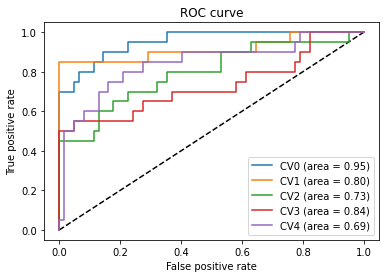

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
for i in range(5):
  plt.plot(fpr_list[i], tpr_list[i],label='CV{} (area = {:.2f})'.format(i,auc[i]))
  plt.legend(loc='CV{}'.format(i))
plt.show()

## Attention Model for Multi Instance Learner

In [0]:
def featureextractor(data):
    conv = Conv2D(20, 5, activation = None, padding = 'same')(data)
    conv_a = Activation('relu')(BatchNormalization()(conv))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv_a)
    conv1 = Conv2D(50, 5, activation = None, padding = 'same')(pool1)
    conv1_a = Activation('relu')(BatchNormalization()(conv1))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
    return pool2

def featureextractorx2(data):
    dense = Dense(500,activation='relu')(data)
    return dense

def Attention(data):
    dense = Dense(128,activation='tanh')(data)
    dense = Dense(128,activation='tanh')(data)
    return dense


In [0]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import keras
from keras.engine import Layer
from keras.regularizers import l1_l2
from keras.layers import Dense,Dropout, Activation,Flatten,Conv2D
from keras.models import Model
from keras import backend as K
l1factor=1e-2
l2factor=0

class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)





model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
logistic = Conv2D(1, 1, activation = 'sigmoid')(model.output)
dense_1 = Flatten()(logistic)
prediction = MaxPool(axis=1)(dense_1)
prediction = Activation("softmax",name="softmax")(prediction)
model = Model(input=model.input, output=prediction)

In [0]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
from keras.layers import Layer
import keras.backend as K
class MaxPool(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(MaxPool, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x, mask=None):
        output=K.placeholder(shape=(x.shape[0],2))
        output=K.concatenate([1-K.max(x, axis=-1,keepdims=True),K.max(x, axis=-1,keepdims=True)])
        return output
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)

In [0]:
import keras
from keras.layers import Conv2D,Flatten
from keras.layers import *
from keras.models import Model
model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3))
Feature_maps = {'conv2_block3_out','conv3_block4_out','conv4_block6_out','conv5_block3_out'}
Features = []

logistic = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv2_block3_out').output)
dense_1 = Flatten()(logistic)

logistic1 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv3_block4_out').output)
dense_2 = Flatten()(logistic1)

logistic2 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv4_block6_out').output)
dense_3 = Flatten()(logistic2)

logistic3 = Conv2D(1, 1, activation = 'sigmoid')(model.get_layer('conv5_block3_out').output)
dense_4 = Flatten()(logistic3)

final = concatenate([dense_1,dense_2,dense_3,dense_4])
prediction = MaxPool(axis=1)(final)
prediction = Activation("softmax",name="softmax")(prediction)
model = Model(input=model.input, output=prediction)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


In [0]:
from keras.preprocessing.image import ImageDataGenerator
noises=50
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45.0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) 
datagen.fit(X_train_extend)

In [0]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train_extend, Y_train,batch_size=2),
                        nb_epoch=100,
                        validation_data=(X_valid_extend, Y_valid))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., epochs=100)`
  import sys


Epoch 1/100
134/134 [==============================] - 35s 264ms/step - loss: 0.6514 - accuracy: 0.7127 - val_loss: 0.8838 - val_accuracy: 0.2667
Epoch 2/100
134/134 [==============================] - 17s 128ms/step - loss: 0.6267 - accuracy: 0.7425 - val_loss: 0.7636 - val_accuracy: 0.4333
Epoch 3/100
134/134 [==============================] - 17s 127ms/step - loss: 0.6024 - accuracy: 0.7836 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 4/100
134/134 [==============================] - 17s 127ms/step - loss: 0.5672 - accuracy: 0.8507 - val_loss: 0.5682 - val_accuracy: 0.8500
Epoch 5/100
134/134 [==============================] - 17s 128ms/step - loss: 0.5584 - accuracy: 0.8433 - val_loss: 0.5442 - val_accuracy: 0.8167
Epoch 6/100
134/134 [==============================] - 17s 130ms/step - loss: 0.5589 - accuracy: 0.8097 - val_loss: 0.5946 - val_accuracy: 0.8333
Epoch 7/100
134/134 [==============================] - 17s 128ms/step - loss: 0.5288 - accuracy: 0.8545 - val_loss: 0.5800 -

In [0]:
model = model5()
print(model.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


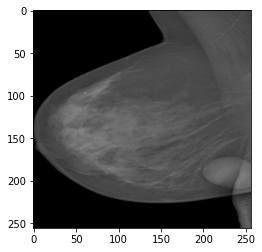

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


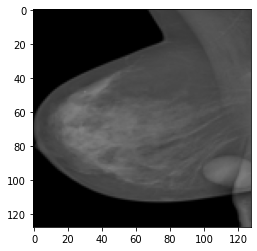

In [50]:
from skimage.transform import resize
from matplotlib import pyplot as plt
image = np.load('TestFold1.npy')
plt.imshow(image[0])
plt.show()
image_resized = resize(image, (image.shape[0] , image.shape[1] // 2,image.shape[2] // 2,image.shape[3]),
                       anti_aliasing=True)
plt.imshow(image_resized[0])
plt.show()